# Low-complexity decentralized algorithm for aggregate load control of thermostatic loads

This notebook contains the code used to generate the figures in the associated paper (reference below) and a few additional figures for verification of the results. If you use this code or the associated library, please reference:

Simon Tindemans and Goran Strbac, "Low-complexity decentralized algorithm for aggregate load control of thermostatic loads", IEEE Transactions on Industry Applications (in press, 2020).

Author: Simon Tindemans, s.h.tindemans@tudelft.nl
Released under the MIT license.

In [1]:
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numba import jit, njit, float64
import scipy.signal as signal
import scipy.stats as stats
import time
import scipy.interpolate

Load TCL controller library

In [2]:
import TCLcontrol

Define plotting options

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

mpl.rcParams['font.size']=7
mpl.rcParams['font.family']='Arial' #['sans-serif']  # might want to specify specific fonts, too, if default is not pretty.
mpl.rcParams['axes.titlesize']='medium'
mpl.rcParams['legend.fontsize']='medium'
mpl.rcParams['axes.linewidth']=0.5
mpl.rcParams['lines.linewidth']=0.5
mpl.rcParams['patch.linewidth']=0.5
mpl.rcParams['lines.color']='k'
mpl.rcParams['figure.figsize']=[3.25,2.5]
mpl.rcParams['figure.dpi']=227/2   # only used for options in plt.clabel() and possibly pixel graphics
mpl.rcParams['savefig.dpi']=227/2  # effective browser resolution on 13 inch retina display

Create function to set random seed within numba-generated code, to aid reproducibility

In [4]:
@njit
def numba_random_seed(seed):
    np.random.seed(seed)

## Define models and control signal

basic model and randomised model generator

In [5]:
# define the nominal model with non-random parameters
basic_model = TCLcontrol.Model(Toff=20, Ton=-44, Tmax=7, Tmin=2, alpha=(1.0/7200), width=0.9)

In [6]:
# ensure that the random factor is generated using the @njit decorator, so that the numba random seed is used for all calculations
@njit
def rfactor():
    return 0.8 + 0.4*np.random.random()

# NOTE: explicit argument naming has been suppressed due to incompatibility with numba. Equivalent non-numba code:
#def random_model():
#    return TCLcontrol.Model(Toff=20*rfactor(), Ton=-44*rfactor(), Tmax=7*rfactor(), Tmin=2*rfactor(), alpha=(1/7200)*rfactor(), width=0.9)

@njit
def random_model():
    return TCLcontrol.Model(20*rfactor(), 
                            -44*rfactor(), 
                            7*rfactor(), 
                            2*rfactor(), 
                            (1/7200)*rfactor(), 
                            0.9)


All calculations use one of three run lengths: one hour (small/short); five hours; twenty-five hours (long)

In [7]:
end_time = 3600
num_steps_small = 360
num_steps = 5*num_steps_small

# default step size is 10s; 1s steps are also used
time_step = end_time / num_steps_small

# define time step arrays
# one hour, 10s steps
time_list_short = np.linspace(0, end_time, num_steps_small, False)
# five hours, 10s and 1s steps
time_list = np.linspace(0, 5*end_time, 5*num_steps_small, False)
time_list_1s = np.linspace(0, 5*end_time, 10*5*num_steps_small, False)
# twenty-five hours, 10s and 1s steps
time_list_long = np.linspace(0, 5*5*end_time, 5*5*num_steps_small, False)
time_list_long_1s = np.linspace(0, 5*5*end_time, 10*5*5*num_steps_small, False)

In [8]:
# this implements the basic physical model for temperature evolution
def update_temperature(initial_temperature, state, time_delta, model):
    return initial_temperature + time_delta*model.alpha*(model.Toff + state*(model.Ton - model.Toff) - initial_temperature)

Create reference power profile

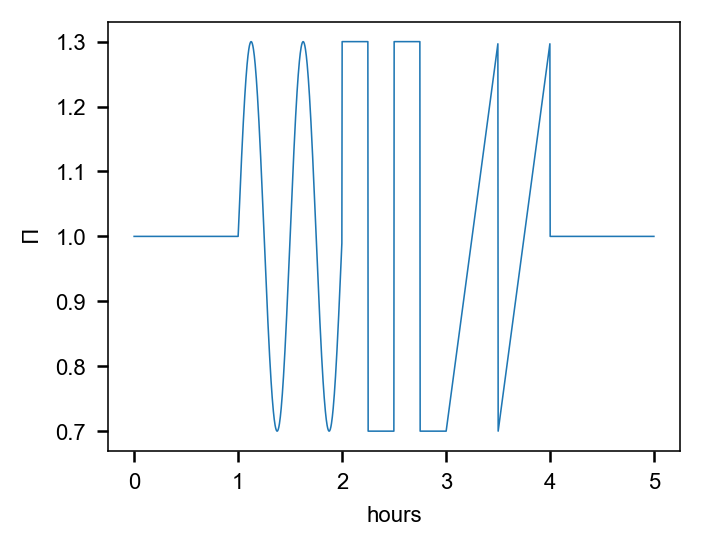

In [9]:
pi_profile1 = np.array([1.0 for time in time_list_short])
pi_profile2 = np.array([1.0 + 0.3 * np.sin(2*np.pi*time/1800) for time in time_list_short])
pi_profile3 = np.array([1.0 + 0.3 * signal.square(2*np.pi*time/1800) for time in time_list_short])
pi_profile4 = np.array([1.0 + 0.3 * signal.sawtooth(2*np.pi*time/1800) for time in time_list_short])

pi_profile = np.concatenate((pi_profile1, pi_profile2, pi_profile3, pi_profile4, pi_profile1))

plt.plot(time_list/3600, pi_profile)
plt.gca().set_xlabel('hours');
plt.gca().set_ylabel('$\Pi$');

Create derived power profiles

In [10]:
# repeat five times (25 hours)
pi_profile_long = np.tile(pi_profile,5)

# create 1s step profiles by repeating each value 10 times
pi_profile_1s = np.repeat(pi_profile,10)
pi_profile_long_1s = np.repeat(pi_profile_long,10)

# create steady state profiles (constant value 1.0)
pi_profile_ss = np.ones(len(pi_profile))
pi_profile_long_ss = np.ones(len(pi_profile_long))

## Single appliance (Section VI.A, Figure 2)

In [11]:
numba_random_seed(12345)

In [12]:
# define arrays for compressor state, temperature, rates and z-values
control_list = np.zeros(num_steps)
temperature_list = np.zeros(num_steps)
rate1_list = np.zeros(num_steps)
rate2_list = np.zeros(num_steps)
z_list = np.zeros(num_steps)

# initialise fridge at t=0 with random state and temperature
current_time = 0   
current_temperature, current_state = TCLcontrol.random_state(basic_model)

# simulate
for i in range(num_steps):
    # update control state
    current_state = TCLcontrol.update_state(
        requested_power=pi_profile[i], 
        current_temperature=current_temperature, 
        current_time=current_time, 
        model=basic_model, 
        previous_state=current_state
    )
    # update temperature 
    current_temperature = update_temperature(current_temperature, current_state.state, time_delta=time_step, model=basic_model)
    # forward time
    current_time += time_step
    
    # save state information
    control_list[i]=current_state.state
    temperature_list[i]=current_temperature
    rate1_list[i] = current_state.rate_off_on
    rate2_list[i] = current_state.rate_on_off
    z_list[i] = current_state.z
    


In [13]:
# compute the scale parameter
def scale(z, model):
    R = model.Tmax if z <= 0.0 else model.Tmin
    return 1.0 - z * (model.Toff - model.Tavg0) / (model.Tavg0 - R)

# compute s values for each time step
s_list = list(map(lambda z : scale(z, basic_model), z_list))

# compute time-dependent minimum and maximum temperatures
def Tminmax(z, model):
    R = model.Tmax if z <= 0.0 else model.Tmin
    scale = 1.0 - z * (model.Toff - model.Tavg0) / (model.Tavg0 - R)
    Tmin = R - (R - model.Tmin)*scale
    Tmax = R - (R - model.Tmax)*scale
    return (Tmin, Tmax)

# compute Tmin, Tmax values for each time step
Tmin_list, Tmax_list = zip(*map(lambda z : Tminmax(z, basic_model), z_list))

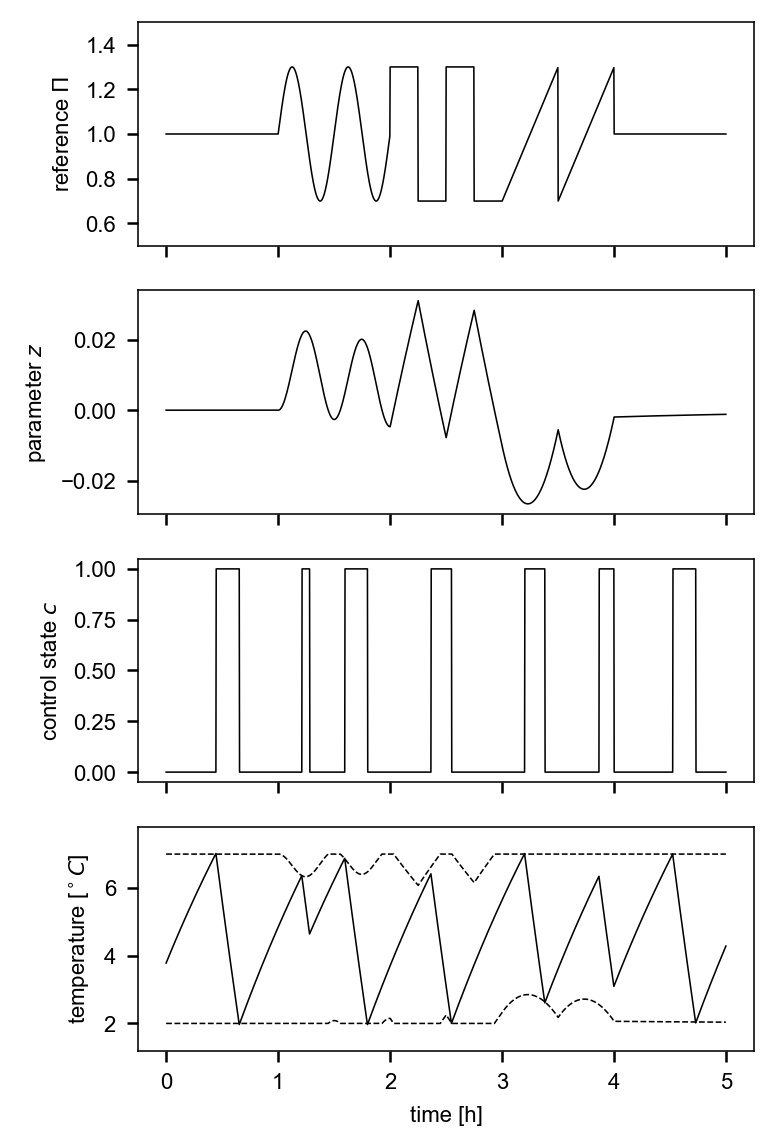

In [14]:
# Four subplots, the axes array is 1-d
fig, axarr = plt.subplots(4, sharex=True)
axarr[0].plot(time_list/3600, pi_profile,'k')
axarr[1].plot(time_list/3600, z_list,'k')
axarr[2].plot(time_list/3600, control_list,'k')
axarr[3].plot(time_list/3600, temperature_list,'k')
axarr[3].plot(time_list/3600, Tmin_list,'k--')
axarr[3].plot(time_list/3600, Tmax_list,'k--')

fig.set_size_inches(3.5,6.0)
axarr[3].set_xlabel('time [h]')
axarr[0].set_ylabel('reference $\Pi$')
axarr[0].set_ylim((0.5,1.5))
axarr[1].set_ylabel('parameter $z$')
axarr[2].set_ylabel('control state $c$')
axarr[3].set_ylabel('temperature [${}^\circ C$]')
axarr[3].set_ylim((1.2,7.8))
fig.savefig('../results/figure2.pdf', bbox_inches="tight")

## Population simulation (Section VI.B, Figure 3)

In [15]:
# JIT-compiled version of the physical temperature model
@njit
def update_temperature(initial_temperature, state, time_delta, model, temp_offset=0.0):
    return initial_temperature + time_delta*model.alpha*(model.Toff + temp_offset + state*(model.Ton - model.Toff - temp_offset) - initial_temperature)

@njit
def run_fridge(time_values, pi_profile, control_model, physics_model = None):
    """Run a single fridge.
    
    Outputs the control trace (array of 0 and 1 values) and a steady state duty cycle."""
    
    # optionally allow for the physics model (for temperature updates) to deviate from the control model
    if physics_model is None:
        physics_model = control_model

    # initialise random fridge state at the first time value, using the physics model.
    current_temperature, current_state = TCLcontrol.random_state(physics_model)
    
    # initialise empty list for control states
    control_list = np.zeros(len(time_values))

    previous_time = time_values[0]
    for i, current_time in enumerate(time_values):

        # first run the physical model to update the cabinet temperature
        current_temperature = update_temperature(current_temperature, current_state.state, time_delta=(current_time - previous_time), model=physics_model)
        
        # update the control state of the fridge
        current_state = TCLcontrol.update_state(
            requested_power=pi_profile[i], 
            current_temperature=current_temperature, 
            current_time=current_time, 
            model=control_model, 
            previous_state=current_state
        )
        # save the control output
        control_list[i]=current_state.state

        # store the current time to compute the time delta
        previous_time = current_time
                

    return control_list, physics_model.pi0

In [16]:
@njit
def run_aggregate(number, time_values, pi_profile, 
                  control_model=None, physics_model=None, random_physics_model=False,
                  seed=None, drop_fraction=0.0):
    """Run an aggregate of 'number' fridges. 
    
        Returns the average control signal (i.e. fraction of 'on' fridges) and average duty cycle.
        """
    if seed is not None:
        numba_random_seed(seed)
        
    control_values = np.zeros(len(time_values), dtype=np.float64)
    duty_cycle = np.zeros(1, dtype=np.float64)
    
    for i in range(number):
        control_model_single = random_model() if control_model is None else control_model
        if random_physics_model:
            physics_model_single = random_model()
        else:
            physics_model_single = physics_model

        # if a physical model is available, initialise the control Tmin, Tmax values from the physical model
        if physics_model_single is not None:
            control_model_single.Tmin = physics_model_single.Tmin
            control_model_single.Tmax = physics_model_single.Tmax
            # re-initialise the average distribution parameters
            control_model_single.update_ss_parameters()

        # determine whether to step through all time steps
        if drop_fraction == 0.0:
            control_single, pi0 = run_fridge(time_values, pi_profile, control_model_single, physics_model_single)
        else:
            random_filter = np.asarray((True,False))[np.random.binomial(n=1, size=len(time_values), p=drop_fraction)]
            random_filter[0] = True
            filtered_time = time_values[random_filter]
            control_single_temp, pi0 = run_fridge(filtered_time, pi_profile[random_filter], control_model_single, physics_model_single)
            result_indices = np.searchsorted(filtered_time, time_values, side='right') - 1
            control_single = control_single_temp[result_indices]
        control_values += control_single
        duty_cycle += pi0
        
    # calculate fraction of 'on' fridges, and steady state duty cycle
    return (1.0/number)*control_values, (1.0/number)*duty_cycle[0]

In [17]:
# generate results for 1000 devices
start = time.time()
results1k, dcycle1k = run_aggregate(1000, time_list, pi_profile, seed=42)
end = time.time()
print(end - start)

4.0480310916900635


In [18]:
# generate results for 100,000 devices
start = time.time()
results100k, dcycle100k = run_aggregate(100000, time_list, pi_profile, seed=12345)
end = time.time()
print(end - start)

35.124699115753174


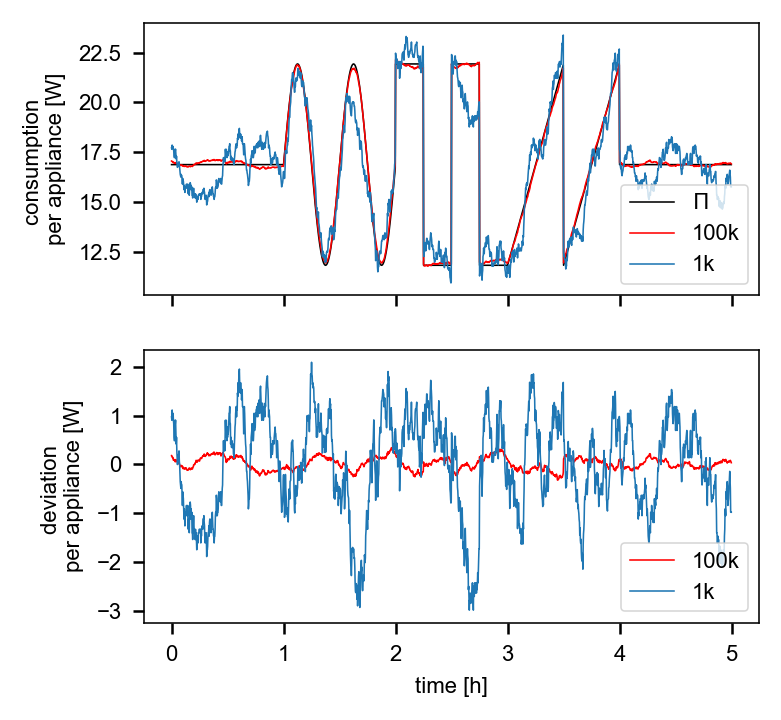

In [19]:
# Two subplots, the axes array is 1-d
fig, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(time_list/3600,70*dcycle100k * pi_profile,'k', label='$\Pi$')
axarr[0].plot(time_list/3600,70*results100k,'r',label='100k')
axarr[0].plot(time_list/3600,70*results1k, label='1k')
axarr[0].legend(loc='lower right')

axarr[1].plot(time_list/3600,70*(results100k- dcycle100k * pi_profile),'r',label='100k')
axarr[1].plot(time_list/3600,70*(results1k- dcycle1k * pi_profile),label='1k')
axarr[1].legend(loc='lower right')

fig.set_size_inches(3.5,3.5)
axarr[1].set_xlabel('time [h]')
axarr[0].set_ylabel('consumption \nper appliance [W]')
axarr[1].set_ylabel('deviation \nper appliance [W]')
fig.savefig('../results/figure3.pdf', bbox_inches="tight")

### Comparing convergence

Compute standard deviations, mean deviations and block-wise estimates of the standard error of the mean (20 blocks), for each population size.

For statistically stable results, run long sequences of 5*5 hours.

In [20]:
# 1k devices, 10s time steps
results1k_long, dcycle1k_long = run_aggregate(1000, time_list_long, pi_profile_long, seed=12345)

In [21]:
# 100k devices, 10s time steps
results100k_long, dcycle100k_long = run_aggregate(100000, time_list_long, pi_profile_long, seed=12345)

In [22]:
# 100k devices, 1s time steps
results100k_long_1s, dcycle100k_long_1s = run_aggregate(100000, time_list_long_1s, pi_profile_long_1s, seed=12345)

In [23]:
print(f"std for 1k devices: {np.std(70*(results1k_long- dcycle1k_long * pi_profile_long)):.3f} W")
print(f"bias for 1k devices: {np.mean(70*(results1k_long- dcycle1k_long * pi_profile_long)):.3f} W \
(+- {scipy.stats.sem(list(map(np.mean, np.split(70*(results1k_long- dcycle1k_long * pi_profile_long), 20)))):.3f} W)")

std for 1k devices: 0.864 W
bias for 1k devices: 0.013 W (+- 0.022 W)


In [24]:
print(f"std for 100k devices: {np.std(70*(results100k_long- dcycle100k_long * pi_profile_long)):.3f} W")
print(f"bias for 100k devices: {np.mean(70*(results100k_long- dcycle100k_long * pi_profile_long)):.3f} W \
(+- {scipy.stats.sem(list(map(np.mean, np.split(70*(results100k_long- dcycle100k_long * pi_profile_long), 20)))):.3f} W)")

std for 100k devices: 0.116 W
bias for 100k devices: 0.013 W (+- 0.004 W)


In [25]:
print(f"std for 100k devices: {np.std(70*(results100k_long_1s- dcycle100k_long_1s * pi_profile_long_1s)):.3f} W")
print(f"bias for 100k devices: {np.mean(70*(results100k_long_1s- dcycle100k_long_1s * pi_profile_long_1s)):.3f} W \
(+- {scipy.stats.sem(list(map(np.mean, np.split(70*(results100k_long_1s- dcycle100k_long_1s * pi_profile_long_1s), 20)))):.3f} W)")

std for 100k devices: 0.098 W
bias for 100k devices: 0.001 W (+- 0.003 W)


## Impact of different time steps (Section VI.C, Figure 4)

In [26]:
# 100k devices, 1s time steps
results100k_1s, dcycle100k_1s = run_aggregate(100000, time_list_1s, pi_profile_1s, seed=12345)

In [27]:
# 100k devices, 60s time steps
results100k_long_step, dcycle100k_long_step = run_aggregate(100000, time_list_long[0::6], pi_profile_long[0::6], seed=12345)

In [28]:
# 100k devices, 20s time steps
results100k_long_20s, dcycle100k_long_20s = run_aggregate(100000, time_list_long[0::2], pi_profile_long[0::2], seed=12345)

In [29]:
# 100k devices, 10s time steps with 50% dropout (20s average)
results100k_long_variable, dcycle100k_long_variable = run_aggregate(100000, time_list_long, pi_profile_long, seed=12345, drop_fraction=0.5)

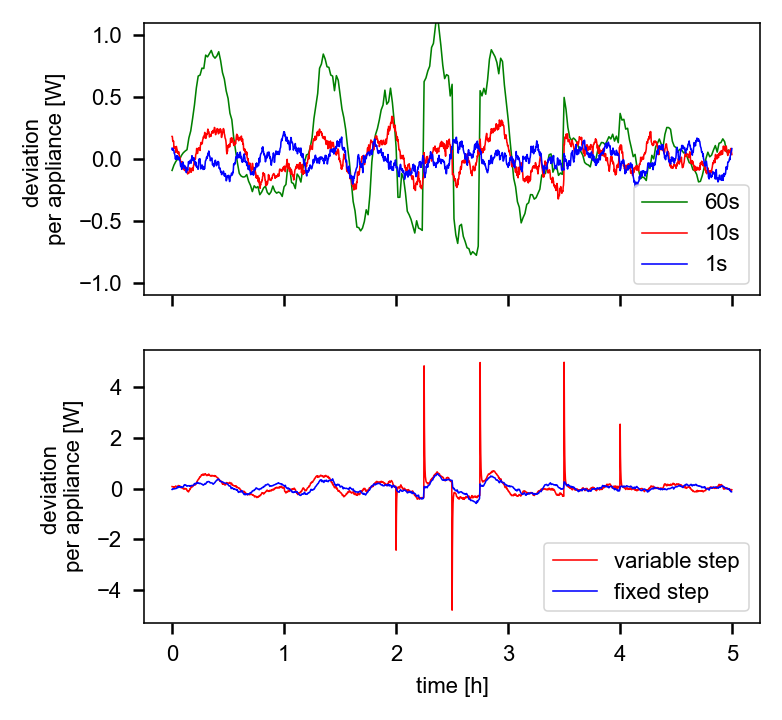

In [30]:
# Two subplots, the axes array is 1-d
fig, axarr = plt.subplots(2, sharex=True)

axarr[0].plot(time_list[0::6]/3600,70*(results100k_long_step[:300] - dcycle100k_long_step * pi_profile_long[0:1800:6]),'g',label='60s')

axarr[0].plot(time_list/3600,70*(results100k- dcycle100k * pi_profile),'r',label='10s')
axarr[0].plot(time_list/3600,70*(results100k_1s[0::10] - dcycle100k_1s * pi_profile_1s[0::10]),'b',label='1s')
axarr[0].legend(loc='lower right')
axarr[0].set_ylim((-1.1,1.1))

axarr[1].plot(time_list/3600,70*(results100k_long_variable[:1800] - dcycle100k_long_variable * pi_profile),color='red',label='variable step')
axarr[1].plot(time_list[0::2]/3600,70*(results100k_long_20s[:900] - dcycle100k_long_20s * pi_profile_long[0:1800:2]),color='blue',label='fixed step')
axarr[1].legend(loc='lower right')

fig.set_size_inches(3.5,3.5)
axarr[1].set_xlabel('time [h]')
axarr[0].set_ylabel('deviation \nper appliance [W]')
axarr[1].set_ylabel('deviation \nper appliance [W]')
fig.savefig('../results/figure4.pdf', bbox_inches="tight")

## Autocorrelation analysis (Section VI.D, Figure 5)

In [31]:
import statsmodels.graphics.tsaplots as tsaplots

In [32]:
# 100k devices, steady state, 10s time steps
results100k_long_ss, dcycle100k_long_ss = run_aggregate(100000, time_list_long, pi_profile_long_ss, seed=12345)

Simulate identical devices

In [33]:
# 100k identical devices, signal tracking, 10s time steps
results100k_long_identical, dcycle100k_long_identical = run_aggregate(100000, time_list_long, pi_profile_long, seed=12345, control_model=basic_model)

In [34]:
# 100k identical devices, signal tracking, 1s time steps
results100k_long_identical_1s, dcycle100k_long_identical_1s = run_aggregate(100000, time_list_long_1s, pi_profile_long_1s, seed=12345, control_model=basic_model)

In [35]:
# 100k identical devices, steady state, 10s time steps
results100k_long_identical_ss, dcycle100k_long_identical_ss = run_aggregate(100000, time_list_long, pi_profile_long_ss, seed=12345, control_model=basic_model)

<ipython-input-36-abf7ef178c14>:4: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  tsaplots.plot_acf(results100k_long - dcycle100k_long * pi_profile_long,
<ipython-input-36-abf7ef178c14>:8: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  tsaplots.plot_acf(results100k_long_1s[0::10] - dcycle100k_long_1s * pi_profile_long_1s[0::10],
<ipython-input-36-abf7ef178c14>:14: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  tsaplots.plot_acf(results100k_long_identical - dcycle100k_long_identical * pi_profile_long, ax=axarr[0,1],
<ipython-input-36-abf7ef178c14>:17: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  tsaplots.plot_acf(results100k_long_identical_1s[0::10] - dcycle100k_long_identical_1s * pi_profile_long_1s[0::10], ax=axarr[0,1], alpha=1,
<ipython-input-36-abf7ef178c14>:22: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  tsaplots.plot_

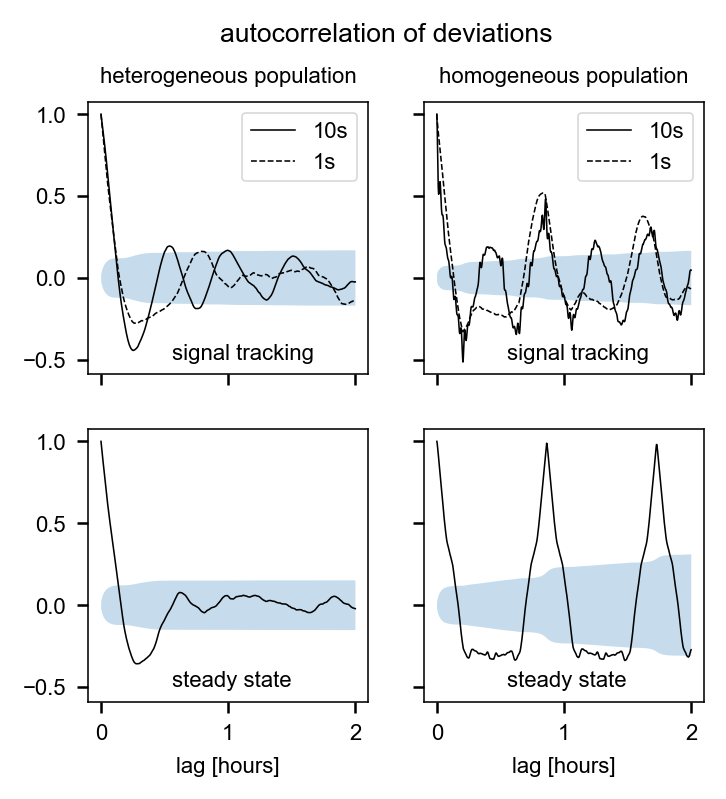

In [36]:
# Two subplots, the axes array is 1-d
fig, axarr = plt.subplots(nrows=2,ncols=2, sharex=True, sharey=True)
fig.set_size_inches(3.5,3.5)
tsaplots.plot_acf(results100k_long - dcycle100k_long * pi_profile_long, 
                  ax=axarr[0,0],
                  lags=720, unbiased=True, use_vlines=False,color='k',title='heterogeneous population', 
                  linestyle='-',marker='',label='10s');
tsaplots.plot_acf(results100k_long_1s[0::10] - dcycle100k_long_1s * pi_profile_long_1s[0::10], 
                  ax=axarr[0,0], alpha=1,
                  lags=720, unbiased=True, use_vlines=False,color='k',title='heterogeneous population', 
                  linestyle='--',marker='', label='1s');
axarr[0,0].text(200,-0.5,'signal tracking')
axarr[0,0].legend(loc='upper right')
tsaplots.plot_acf(results100k_long_identical - dcycle100k_long_identical * pi_profile_long, ax=axarr[0,1],
                  lags=720, unbiased=True, use_vlines=False, title='homogeneous population',
                  color='k',linestyle='-',marker='', label='10s');
tsaplots.plot_acf(results100k_long_identical_1s[0::10] - dcycle100k_long_identical_1s * pi_profile_long_1s[0::10], ax=axarr[0,1], alpha=1,
                  lags=720, unbiased=True, use_vlines=False, title='homogeneous population',
                  color='k',linestyle='--',marker='', label='1s');
axarr[0,1].text(200,-0.5,'signal tracking')
axarr[0,1].legend(loc='upper right')
tsaplots.plot_acf(results100k_long_ss - dcycle100k_long_ss * pi_profile_long_ss, ax=axarr[1,0],
                  lags=720, unbiased=True, use_vlines=False, title='',color='k',linestyle='-',marker='');
axarr[1,0].text(200,-0.5,'steady state')
tsaplots.plot_acf(results100k_long_identical_ss - dcycle100k_long_identical_ss * pi_profile_long_ss, ax=axarr[1,1],
                  lags=720, unbiased=True, use_vlines=False, title='',color='k',linestyle='-',marker='');
axarr[1,1].text(200,-0.5,'steady state')
axarr[1,0].set_xticks(np.arange(0, 721, 360));
axarr[1,0].set_xticklabels([0,1,2]);
axarr[1,0].set_xlabel('lag [hours]')
axarr[1,1].set_xlabel('lag [hours]')
fig.suptitle('autocorrelation of deviations')
fig.savefig('../results/figure5.pdf', bbox_inches="tight")

## Model error (Section VI.E, Figure 6)

Investigate two types of model error

In [37]:
# 100k heterogeneous devices, independent random draws for physics model (temperature) and control model
results100k_model_error, dcycle100k_model_error = run_aggregate(100000, time_list, pi_profile, random_physics_model=True, seed=12345)

In [38]:
# 100k heterogeneous devices, random physics models, but sharing a common 'nominal' control model
results100k_model_fixed, dcycle100k_model_fixed = run_aggregate(100000, time_list, pi_profile, control_model=basic_model, random_physics_model=True, seed=12345)

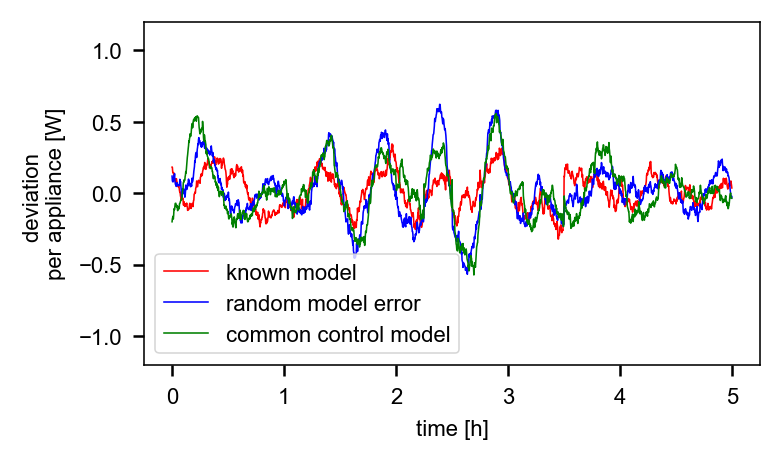

In [39]:
# Two subplots, the axes array is 1-d
fig = plt.gcf()

plt.plot(time_list/3600,70*(results100k- dcycle100k * pi_profile),'r',label='known model')
plt.plot(time_list/3600,70*(results100k_model_error - dcycle100k_model_error * pi_profile),'b',label='random model error')
plt.plot(time_list/3600,70*(results100k_model_fixed - dcycle100k_model_fixed * pi_profile),'g', label='common control model')
plt.legend(loc='lower left')

fig.set_size_inches(3.5,2.)
fig.gca().set_xlabel('time [h]')
fig.gca().set_ylabel('deviation \nper appliance [W]')
plt.ylim([-1.2,1.2])
fig.savefig('../results/figure6.pdf', bbox_inches="tight")

## Door openings (Section VI.F, Figure 7)

In [40]:
openings_per_day = 20
open_duration = 20 # seconds
open_conductance_multiplier = 25

In [41]:
pr_open_hour = np.array([0.0325, 0.0135, 0.0055, 0.0045, 0.0025, 0.0035, 0.0035, 0.0385, 0.0575, 0.0295, 0.0315, 0.0345, 0.0385, 0.0315, 0.0755, 0.0785, 0.0285, 0.0285, 0.0375, 0.0825, 0.1405, 0.0825, 0.0715, 0.0475])
sum(pr_open_hour)

1.0

In [42]:
rate_open_per_second = openings_per_day * pr_open_hour / (60*60)

In [43]:
rate_open_per_second

array([1.80555556e-04, 7.50000000e-05, 3.05555556e-05, 2.50000000e-05,
       1.38888889e-05, 1.94444444e-05, 1.94444444e-05, 2.13888889e-04,
       3.19444444e-04, 1.63888889e-04, 1.75000000e-04, 1.91666667e-04,
       2.13888889e-04, 1.75000000e-04, 4.19444444e-04, 4.36111111e-04,
       1.58333333e-04, 1.58333333e-04, 2.08333333e-04, 4.58333333e-04,
       7.80555556e-04, 4.58333333e-04, 3.97222222e-04, 2.63888889e-04])

In [44]:
rate_list_long = np.repeat(np.concatenate([rate_open_per_second, rate_open_per_second[0:1]]), 360)

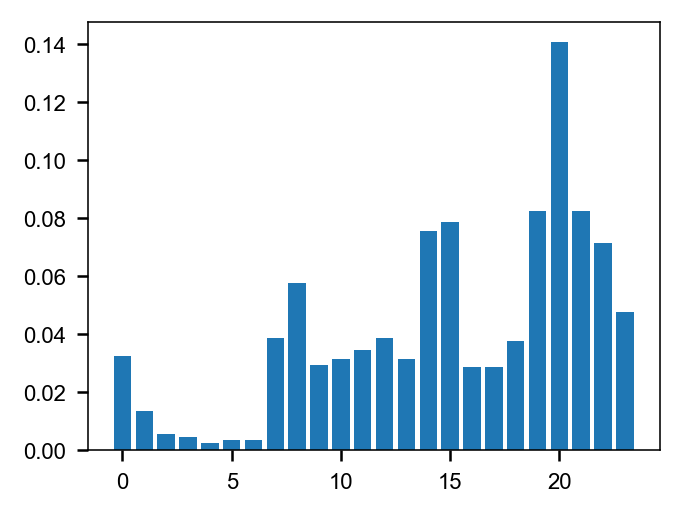

In [45]:
plt.bar(np.arange(len(pr_open_hour)),pr_open_hour);

In [46]:
# JIT-compiled version of the physics model
@njit
def update_temperature_with_door(initial_temperature, state, time_delta, model, temp_offset=0.0, conductance_multiplier=1.0):
    return initial_temperature + time_delta*model.alpha*(conductance_multiplier*(model.Toff + temp_offset - initial_temperature) + state*(model.Ton - model.Toff - temp_offset))


@njit
def run_fridge_with_door(time_values, pi_profile, door_opening_profile, control_model, physics_model = None, open_duration=20.0, open_conductance_multiplier = 25.0):
    """Run a single fridge with random door openings.
    
    Outputs the control trace (array of 0 and 1 values) and a steady state duty cycle."""
    
    # optionally allow for the physics model (for temperature updates) to deviate from the control model
    if physics_model is None:
        physics_model = control_model

    
    # initialise random fridge state at the first time value, using the physics model.
    current_temperature, current_state = TCLcontrol.random_state(physics_model)
    
    # initialise empty list for control states
    control_list = np.zeros(len(time_values))

    previous_time = time_values[0]
    door_open = False
    
    for i, current_time in enumerate(time_values):

        time_delta = current_time - previous_time

        # check whether a door opening takes place. 
        # Note that this can also occur when the door is already open. In that case, the counter is reset.
        if np.random.random() < time_delta * door_opening_profile[i]:
            door_open = True
            open_time_remaining = open_duration

        # if the door is open, count down the time and compute the effective conductance multiplier
        if door_open:
           
            # calculate the effective thermal conductance multiplier, according to the fraction of time the door is open
            if open_time_remaining > time_delta:
                open_time_remaining -= time_delta
                effective_conductance_multiplier = open_conductance_multiplier
            else:
                effective_conductance_multiplier = 1.0 + open_time_remaining / time_delta * (open_conductance_multiplier - 1.0)
                door_open = False
                open_time_remaining = 0
                
            temperature_time_step_count = np.round(effective_conductance_multiplier)

        else:
            effective_conductance_multiplier = 1.0
            temperature_time_step_count = 1.0
            
        # run the physical model to update the cabinet temperature
        # make smaller time steps if the effective conductance multiplier is > 1
        temperature_time_step = time_delta / temperature_time_step_count
        for _ in range(temperature_time_step_count):
            current_temperature = update_temperature_with_door(current_temperature, 
                                                               current_state.state, 
                                                               time_delta=temperature_time_step, 
                                                               model=physics_model,
                                                               conductance_multiplier=effective_conductance_multiplier)
        
        # update the control state of the fridge
        current_state = TCLcontrol.update_state(
            requested_power=pi_profile[i], 
            current_temperature=current_temperature, 
            current_time=current_time, 
            model=control_model, 
            previous_state=current_state
        )
        # save the control output
        control_list[i]=current_state.state

        # store the current time to compute the time delta
        previous_time = current_time
                
    return control_list, physics_model.pi0

In [47]:
@njit
def run_aggregate_with_door(number, 
                            time_values, pi_profile, door_opening_profile,
                            control_model=None, physics_model=None, random_physics_model=False,
                            open_duration=20.0, open_conductance_multiplier = 25.0,
                            seed=None, drop_fraction=0.0):
    """Run an aggregate of 'number' fridges. 
    
        Returns the average control signal and duty cycle over the population.
        """
    if seed is not None:
        numba_random_seed(seed)
        
    control_values = np.zeros(len(time_values), dtype=np.float64)
    duty_cycle = np.zeros(1, dtype=np.float64)
    
    for i in range(number):
        control_model_single = random_model() if control_model is None else control_model
        if random_physics_model:
            physics_model_single = random_model()
        else:
            physics_model_single = physics_model

        # if a physical model is available, initialise the control Tmin, Tmax values from the physical model
        if physics_model_single is not None:
            control_model_single.Tmin = physics_model_single.Tmin
            control_model_single.Tmax = physics_model_single.Tmax
            # re-initialise the average distribution parameters
            control_model_single.update_ss_parameters()

        if drop_fraction == 0.0:
            control_single, pi0 = run_fridge_with_door(time_values, pi_profile, door_opening_profile,
                                                       control_model_single, physics_model_single, 
                                                       open_duration, open_conductance_multiplier)
        else:
            random_filter = np.asarray((True,False))[np.random.binomial(n=1, size=len(time_values), p=drop_fraction)]
            random_filter[0] = True
            filtered_time = time_values[random_filter]
            control_single_temp, pi0 = run_fridge_with_door(filtered_time, pi_profile[random_filter], door_opening_profile[random_filter],
                                                            control_model_single, physics_model_single, 
                                                            open_duration, open_conductance_multiplier)
            result_indices = np.searchsorted(filtered_time, time_values, side='right') - 1
            control_single = control_single_temp[result_indices]
        control_values += control_single
        duty_cycle += pi0
        
    return (1.0/number)*control_values, (1.0/number)*duty_cycle[0]

In [48]:
# generate results for 100k fridges with random door openings, steady state, 24 hours, 10s time steps
results100k_door_ss, dcycle100k_door_ss = run_aggregate_with_door(100000, 
                                                                  time_list_long[:8640], 
                                                                  pi_profile_long_ss[:8640], 
                                                                  rate_list_long[:8640], 
                                                                  open_duration=open_duration, 
                                                                  open_conductance_multiplier=open_conductance_multiplier,
                                                                  seed=12345)

Statistics for the steady state results (with door openings) show 11% higher power consumption on average than the steady state without door openings, and 44% higher at the peak.

In [49]:
stats.describe(results100k_door_ss/dcycle100k_door_ss)

DescribeResult(nobs=8640, minmax=(0.9866958183055045, 1.4415103144455694), mean=1.1089427889566963, variance=0.007727562609108592, skewness=1.1521101491962142, kurtosis=1.5069271740337564)

In [50]:
# generate results for 100k fridges with random door openings, signal tracking, 24 hours, 10s time steps
results100k_door, dcycle100k_door = run_aggregate_with_door(100000, 
                                                                  time_list_long[:8640], 
                                                                  pi_profile_long[:8640], 
                                                                  rate_list_long[:8640], 
                                                                  open_duration=open_duration, 
                                                                  open_conductance_multiplier=open_conductance_multiplier,
                                                                  seed=12345)

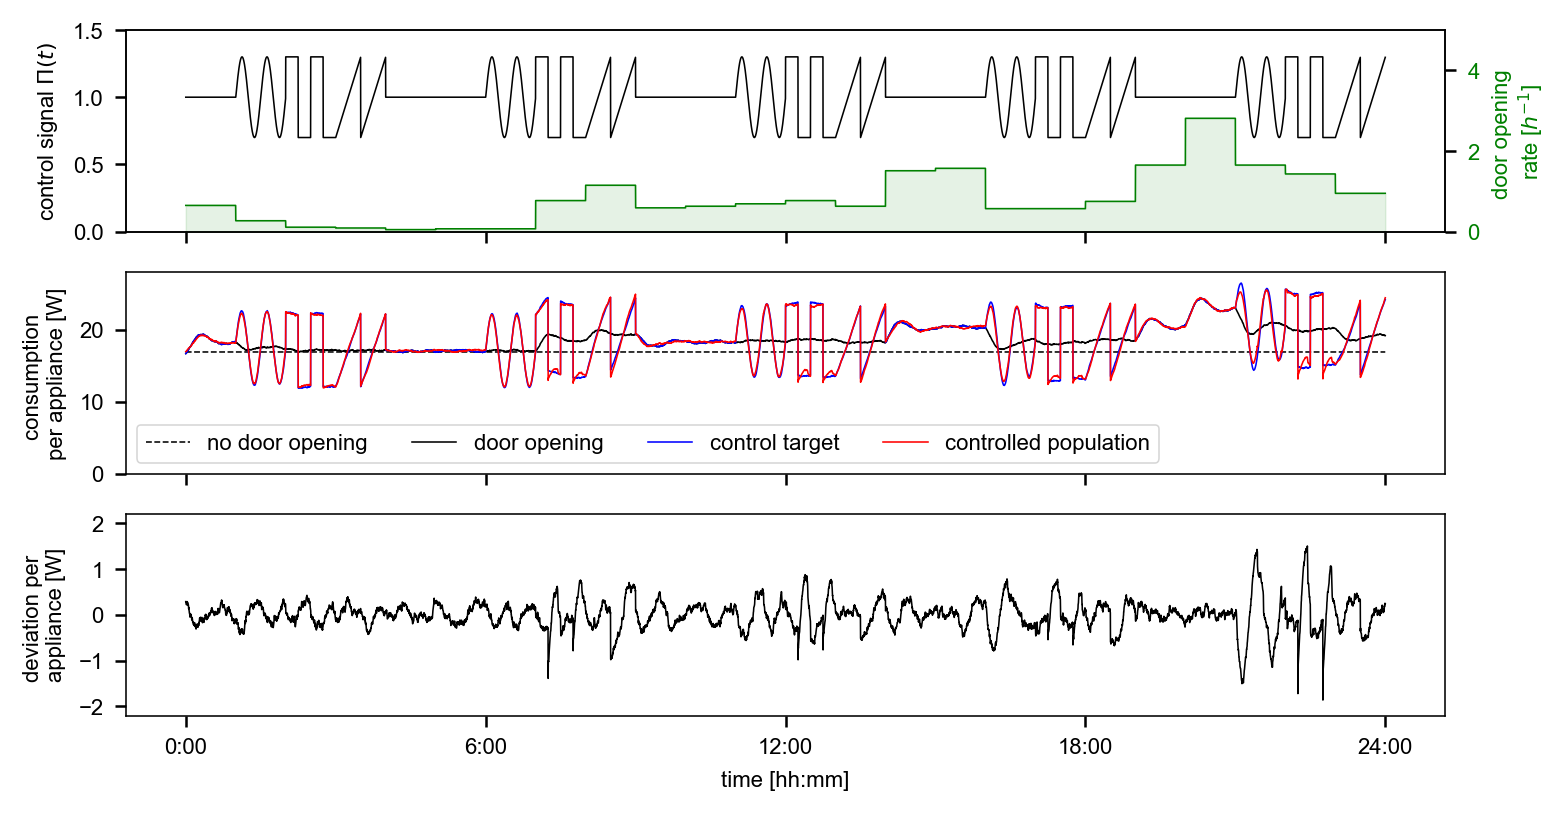

In [51]:
# Two subplots, the axes array is 1-d
fig, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(time_list_long[:8640]/3600,pi_profile_long[:8640],'k')
axarr[0].set_ylim([0,1.5])

ax_extra = axarr[0].twinx()
ax_extra.set_ylabel('door opening \nrate [$h^{-1}$]', color='g') 
ax_extra.set_ylim([0,5])
ax_extra.tick_params(axis='y', labelcolor='g')
ax_extra.plot(time_list_long[:8640]/3600, 3600*rate_list_long[:8640], 'g')
ax_extra.fill_between(time_list_long[:8640]/3600, 0, 3600*rate_list_long[:8640], color='g', alpha=0.1)

axarr[1].plot(time_list_long[:8640]/3600,70*dcycle100k_door_ss*np.ones(len(results100k_door)), 'k--', label='no door opening')
axarr[1].plot(time_list_long[:8640]/3600,70*(results100k_door_ss),'k',label='door opening')
axarr[1].plot(time_list_long[:8640]/3600,70*(results100k_door_ss + dcycle100k_door_ss * (pi_profile_long[:8640]-1)),'b',label='control target')
axarr[1].plot(time_list_long[:8640]/3600,70*(results100k_door),'r',label='controlled population')

axarr[1].legend(loc='lower left', ncol=4)
axarr[1].set_ylim([0,28])
axarr[1].set_yticks(ticks=(0,10,20))

axarr[2].plot(time_list_long[:8640]/3600,70*(results100k_door - results100k_door_ss  -(pi_profile_long[:8640]-1) *  dcycle100k_door_ss ),'k')
axarr[2].set_yticks(ticks=(-2,-1,0,1,2))
axarr[2].set_ylim([-2.2,2.2])

fig.set_size_inches(7.5,4)
axarr[2].set_xlabel('time [hh:mm]')
axarr[2].set_xticks(ticks=(0,6,12,18,24))
axarr[2].set_xticklabels(labels=('0:00','6:00','12:00','18:00','24:00'))
axarr[0].set_ylabel('control signal $\Pi(t)$')
axarr[1].set_ylabel('consumption \nper appliance [W]')
axarr[2].set_ylabel('deviation per \nappliance [W]')
fig.savefig('../results/figure7.pdf', bbox_inches="tight")